![Py4Eng](../logo.png)

# Finetuning pretrained model
## Yoav Ram

This notebook shows a simple, step-by-step finetuning workflow using a pretrained [EfficientNetV2](https://arxiv.org/pdf/2104.00298) backbone (from `timm`) and PyTorch. The target dataset is the [Hyena ID 2022](https://lila.science/datasets/hyena-id-2022/) dataset (3104 photos, 256 individuals) — the task is per-individual classification.

We will load the pretrained model using [`timm`](https://timm.fast.ai), a collection of state-of-the-art computer vision models. Install it with `pip install timm`.

In [1]:
%matplotlib inline
import os
import shutil
from collections import Counter
import tarfile
import urllib.request
import random
from tqdm import tqdm
from pathlib import Path
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_metric_learning.losses import ArcFaceLoss

print('torch', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

torch 2.7.1
Device: mps


# Data

We Download the [Hyena ID 2022 dataset](https://lila.science/datasets/hyena-id-2022/) and extract to `data/hyena`. 

In [2]:
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
chunk = 1024 * 1024

os.makedirs(os.path.dirname(out_path), exist_ok=True)

In [3]:
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        with urllib.request.urlopen(url) as r, open(out_path, 'wb') as f:
            total = r.getheader('Content-Length')
            total = int(total) if total else None
            with tqdm(total=total, unit='B', unit_scale=True, desc='download') as p:
                while True:
                    data = r.read(chunk)
                    if not data:
                        break
                    f.write(data)
                    p.update(len(data))
    else:
        print(f'File {out_path} already exists, skipping download.')

    print(f"Extracting {out_path}")
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print(f'Extraction directory already exists, skipping extraction.')

Extraction directory already exists, skipping extraction.



The metadata is in `../data/hyena/hyena.coco/annotations/instances_train2022.json`, which contains the bounding box of the individuals in the images, as well as their the identities.

Load COCO-style annotations and build mapping from filename to identity.

In [4]:
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json', 'r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}

All the hyena images are now in `../data/hyena/hyena.coco/images/train2022` folder (`test2022` and `val2022` are empty). Image filenames are just the image running number.

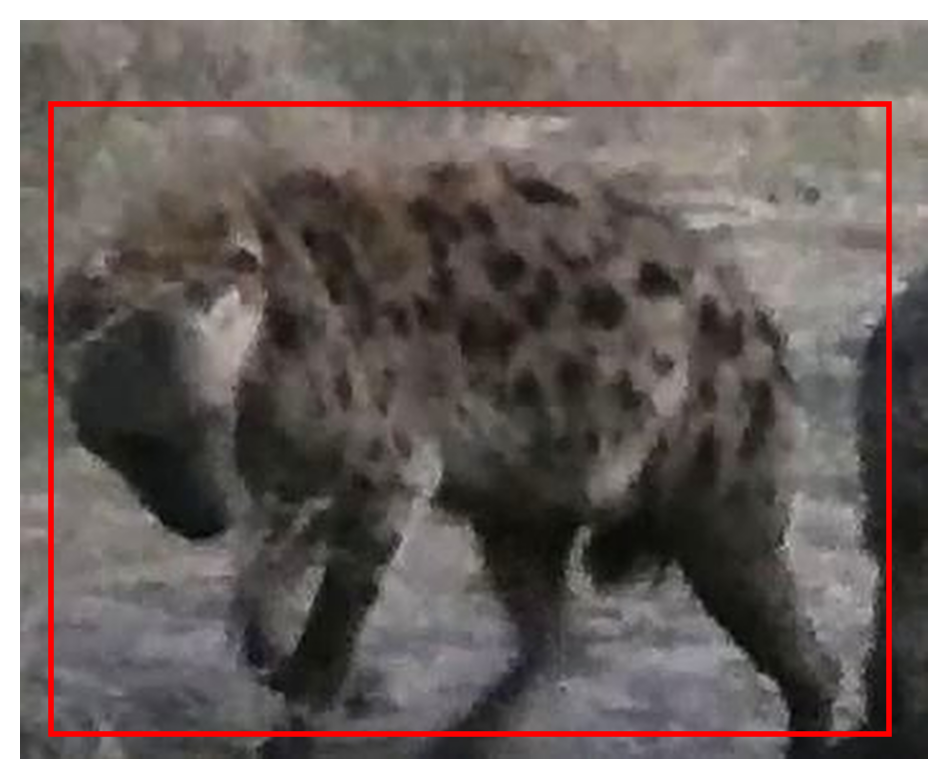

In [5]:
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'

def plot_image(image_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    path = path_template.format(image_id)
    image = Image.open(path)    
    ax.imshow(image)
    bbox = bboxes[image_id]
    x, y, w, h = bbox  # Top-Left X, Top-Left Y, Width, Height
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', lw=2)
    ax.add_patch(rect)
    ax.axis('off')
    return ax

plot_image(np.random.randint(1, len(bboxes)+1));

Now we get the labels -- individual names.

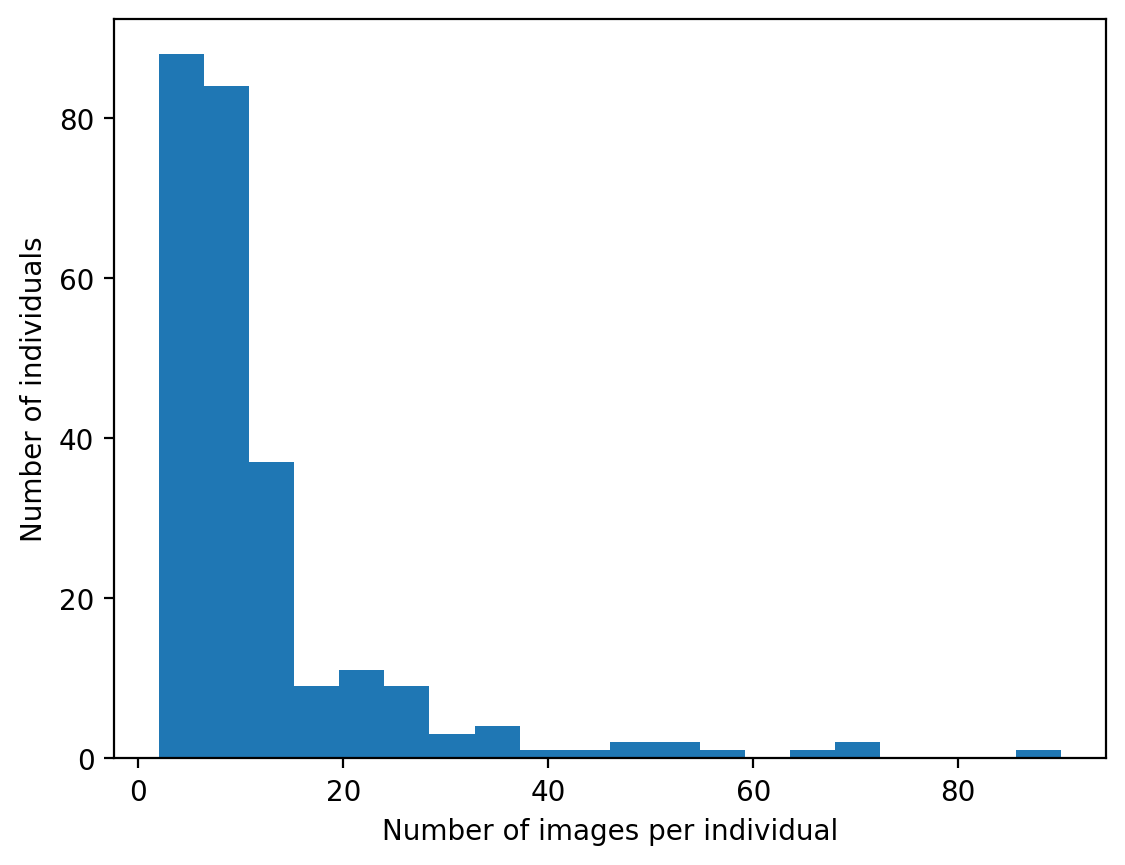

In [6]:
img2name = {a['image_id']: a['name'] for a in metadata['annotations']}
img_ids = np.array(list(img2name.keys()))

counter = Counter(img2name.values())
plt.hist(counter.values(), 20)
plt.xlabel('Number of images per individual')
plt.ylabel('Number of individuals');

Map names to integers and back.

In [7]:
name2id = {k:i for i,k in enumerate(counter.keys())}
int2name = {i:k for k,i in name2id.items()}
labels = np.array([name2id[img2name[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print("Number of classes:", n_classes)

Number of classes: 256


Split to train and test sets by defining the indexes that go to either set.

In [8]:
rng = np.random.default_rng(23)
# Use a stratified split so each individual is represented in train and val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print("Number of train samples {}\nNumber of validation samples {}".format(len(train_idx), len(val_idx)))

Number of train samples 2793
Number of validation samples 311


We now define a dataset class that takes image identifiers and their corresponding labels and on each iteration loads and returns an image and its label.

In [9]:
class HyenaDataset(Dataset):    
    def __init__(self, img_ids, labels, transform=None):
        assert len(img_ids) == len(labels)
        self.img_ids = img_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        image_id = self.img_ids[idx]
        label = self.labels[idx]
        path = path_template.format(image_id)
        image = Image.open(path).convert('RGB')
        # crop to bbox
        bbox = bboxes[image_id]
        x, y, w, h = bbox
        image = image.crop((x, y, x + w, y + h))
        if self.transform:
            image = self.transform(image)
        return image, label
    

Definte the image transforms: resize to the image size suitable for the model, convert to PyTorch tensor, and normalize colors. For the training transforms, we also augment the data using horizontal flips.

In [10]:
img_size = 224

val_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    # T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transforms = T.Compose([
    # stronger augmentation to improve generalization
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

Now we create the datasets and data loaders.

In [11]:
batch_size = 32

train_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=train_transforms)
val_ds = HyenaDataset(img_ids=img_ids[val_idx], labels=labels[val_idx], transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

Here's how the images look like coming out of the data set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..0.60493195].


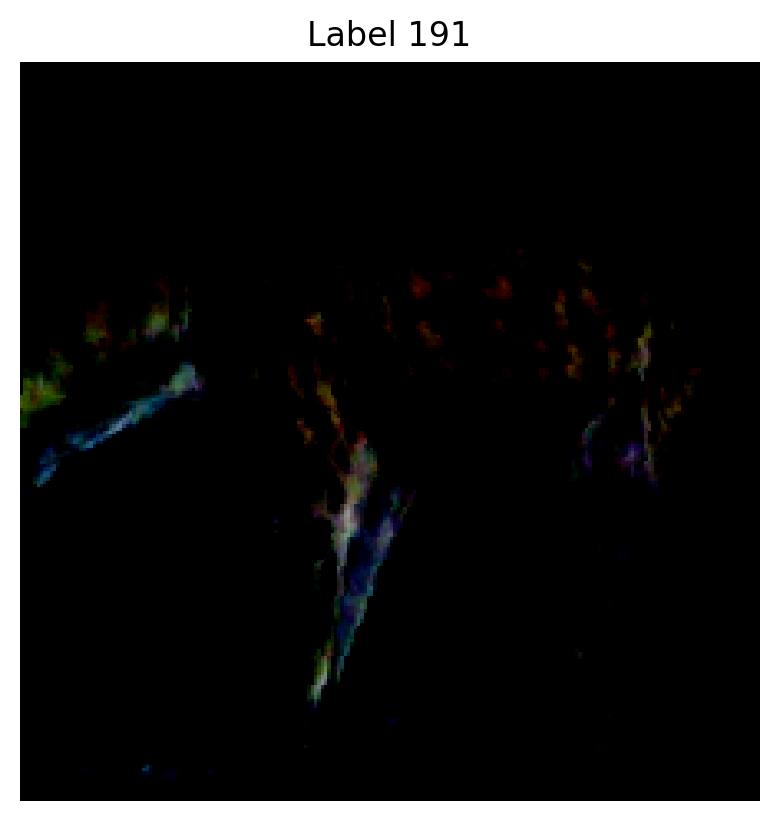

In [12]:
img, lbl = next(iter(train_ds))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Label {lbl}');

## Model
Load a pretrained **EfficientNetV2_s** without the classifier head. We use the small variant `_s` for speed; change to `_m` or `_l` if you want.
See [model card](https://huggingface.co/timm/tf_efficientnetv2_s.in21k_ft_in1k) for details.

In [22]:
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True, # 
    num_classes=0,  # remove classifier
)

In [23]:
model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

Let's see the model in action. Because we specificed `num_classes=0`, the output is the last activation (that the classifier used as input during pretraining), which is called the **embedding**.

In [24]:
embedding = model(img.unsqueeze(0).to(device))
print("Embedding shape:", embedding.shape)
print(embedding)

Embedding shape: torch.Size([1, 1280])
tensor([[0.3460, 0.4548, 0.4142,  ..., 0.4665, 0.5440, 0.5679]],
       device='mps:0', grad_fn=<ViewBackward0>)


We now create the [ArcFace loss](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#arcfaceloss) function. Note that this loss function is parameterized--it has weights for a linear classification layer.

In [25]:
loss_fn = ArcFaceLoss(num_classes=n_classes, embedding_size=embedding.shape[1], margin=0.5, scale=30.0)
loss_fn = loss_fn.to(device)

We now move the model to the device (gpu/mps/cpu) and print it.

### Freeze backbone and train classifier head
We freeze all parameters except the classifier parameters.

In [26]:
# Freeze backbone
for p in model.parameters():
    p.requires_grad = False
# Train the loss function parameters
for p in loss_fn.parameters():
    p.requires_grad = True

Define an optimizer for the model parameters and for the loss function parameters. Use *AdamW* with small weight decay to reduce overfitting.

In [27]:
loss_optimizer = torch.optim.AdamW(loss_fn.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

Define a function to train the model for one epoch and another function to evaluate it at the end of the epoch.

In [28]:
def train(model, loss_fn, data_loader, optimizer, loss_optimizer):
    model.train()
    running_loss = 0.0 # for the entire epoch
    pbar = tqdm(data_loader, desc='Training', unit='batch')
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        emb = model(x)
        loss = loss_fn(emb, y)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix({'loss': f'{loss:.4f}'})
    return running_loss / len(data_loader.dataset)

In [29]:
def evaluate(model, loss_fn, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            emb = model(x)            
            logits = emb @ loss_fn.W
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total if total else 0.0

Now let's train just the ArcFace classifier (the backbone is frozen) for 3 epochs.

In [ ]:
val_acc = []
train_acc = []
n_epochs = 10
epoch = 0
train_acc.append(evaluate(model, loss_fn, train_loader))
val_acc.append(evaluate(model, loss_fn, val_loader))
print(f'Before training: tr acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer, loss_optimizer)
    train_acc.append(evaluate(model, loss_fn, train_loader))
    val_acc.append(evaluate(model, loss_fn, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train acc {train_acc[-1]:.4f} | val acc {val_acc[-1]:.4f}')
    epoch += 1

### Unfreeze and finetune the whole model
Now we unfreeze all parameters and create a new optimizer for all the parameters with a lower learning rate.

In [ ]:
for p in model.parameters():
    p.requires_grad = True

Now continue training the entire model (backbone+head).
This typically improves performance but takes longer - 70 min of a MacBookPro 2025 with MPS.

In [ ]:
n_epochs += 100
print(f'Before training: val_acc {val_acc[-1]:.4f}')
while epoch < n_epochs:
    loss = train(model, loss_fn, train_loader, optimizer, loss_optimizer)
    train_acc.append(evaluate(model, loss_fn, train_loader))
    val_acc.append(evaluate(model, loss_fn, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | train_acc {train_acc[-1]:.4f} | val_acc {val_acc[-1]:.4f}')
    epoch += 1

Before training: val_acc 0.0450


Training: 100%|██████████| 88/88 [01:20<00:00,  1.09batch/s, loss=4.9502]



Epoch 1/50: loss 5.2361 | val_acc 0.0611


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=4.1916]



Epoch 2/50: loss 4.9466 | val_acc 0.1125


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=4.3912]



Epoch 3/50: loss 4.6805 | val_acc 0.1286


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=5.0951]



Epoch 4/50: loss 4.4114 | val_acc 0.1511


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=4.2002]



Epoch 5/50: loss 4.1896 | val_acc 0.1801


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=4.5080]



Epoch 6/50: loss 3.9716 | val_acc 0.2058


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=3.3197]



Epoch 7/50: loss 3.7502 | val_acc 0.2347


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=3.6857]



Epoch 8/50: loss 3.5635 | val_acc 0.2508


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=3.2944]



Epoch 9/50: loss 3.4106 | val_acc 0.2765


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=3.4659]



Epoch 10/50: loss 3.2291 | val_acc 0.3151


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=4.1097]



Epoch 11/50: loss 3.0772 | val_acc 0.3505


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=3.1096]



Epoch 12/50: loss 2.8960 | val_acc 0.3859


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.7076]



Epoch 13/50: loss 2.7726 | val_acc 0.4084


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.5721]



Epoch 14/50: loss 2.6185 | val_acc 0.4180


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=3.0234]



Epoch 15/50: loss 2.4928 | val_acc 0.4309


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=2.7290]



Epoch 16/50: loss 2.3866 | val_acc 0.4534


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=3.0531]



Epoch 17/50: loss 2.2625 | val_acc 0.4727


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=2.4235]



Epoch 18/50: loss 2.1558 | val_acc 0.4823


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.8700]



Epoch 19/50: loss 2.0152 | val_acc 0.4855


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.2453]



Epoch 20/50: loss 1.9210 | val_acc 0.4952


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.9674]



Epoch 21/50: loss 1.8346 | val_acc 0.5080


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.1369]



Epoch 22/50: loss 1.7290 | val_acc 0.5338


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=2.3668]



Epoch 23/50: loss 1.6464 | val_acc 0.5305


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=2.5743]



Epoch 24/50: loss 1.5477 | val_acc 0.5402


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.1739]



Epoch 25/50: loss 1.4615 | val_acc 0.5820


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.0759]



Epoch 26/50: loss 1.3994 | val_acc 0.5756


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.6447]



Epoch 27/50: loss 1.3096 | val_acc 0.6077


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.6914]



Epoch 28/50: loss 1.2258 | val_acc 0.6109


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.4532]



Epoch 29/50: loss 1.1425 | val_acc 0.6174


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=0.5800]



Epoch 30/50: loss 1.0695 | val_acc 0.6141


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.5186]



Epoch 31/50: loss 0.9939 | val_acc 0.6174


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.2444]



Epoch 32/50: loss 0.9392 | val_acc 0.6109


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=0.8127]



Epoch 33/50: loss 0.8764 | val_acc 0.6302


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.2625]



Epoch 34/50: loss 0.8278 | val_acc 0.6334


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.2794]



Epoch 35/50: loss 0.7793 | val_acc 0.6302


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.3614]



Epoch 36/50: loss 0.7146 | val_acc 0.6431


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=0.8850]



Epoch 37/50: loss 0.6428 | val_acc 0.6495


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=0.5682]



Epoch 38/50: loss 0.6296 | val_acc 0.6334


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=0.6859]



Epoch 39/50: loss 0.5873 | val_acc 0.6559


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.2720]



Epoch 40/50: loss 0.5385 | val_acc 0.6592


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.6605]



Epoch 41/50: loss 0.4971 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.9262]



Epoch 42/50: loss 0.4660 | val_acc 0.6752


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=1.3841]



Epoch 43/50: loss 0.4381 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:18<00:00,  1.13batch/s, loss=0.5869]



Epoch 44/50: loss 0.3980 | val_acc 0.6688


Training: 100%|██████████| 88/88 [01:18<00:00,  1.13batch/s, loss=0.8398]



Epoch 45/50: loss 0.3745 | val_acc 0.6688


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.4578]



Epoch 46/50: loss 0.3459 | val_acc 0.6977


Training: 100%|██████████| 88/88 [01:18<00:00,  1.13batch/s, loss=1.5306]



Epoch 47/50: loss 0.3359 | val_acc 0.6849


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.7130]



Epoch 48/50: loss 0.2999 | val_acc 0.6849


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.6152]



Epoch 49/50: loss 0.2767 | val_acc 0.6977


Training: 100%|██████████| 88/88 [01:17<00:00,  1.13batch/s, loss=0.5553]



Epoch 50/50: loss 0.2684 | val_acc 0.7042


In [ ]:
ckpt_path = f'../data/{model_name}_finetune.pth'

torch.save({    
    'model_state_dict': model.state_dict(),
    'loss_fn_state_dict': loss_fn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_optimizer_state_dict': loss_optimizer.state_dict(),
    'model_name': model_name,
    'train_acc': train_acc,
    'val_acc': val_acc,
}, ckpt_path)
print(f'Checkpoint saved to {ckpt_path}')

Checkpoint saved to ../data/tf_efficientnetv2_s.in21k_ft_in1k_finetune.pth


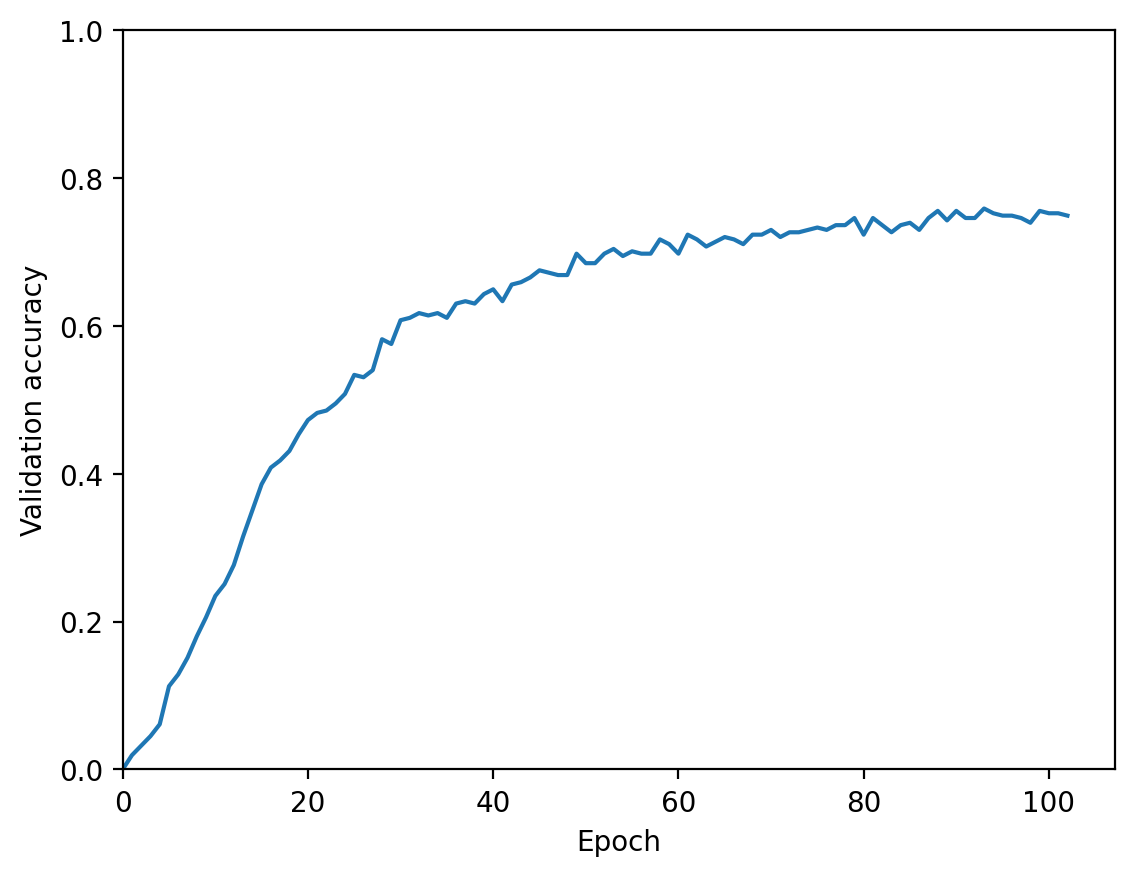

In [ ]:
plt.plot(val_acc, label='Validation')
plt.plot(train_acc, label='Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, None);